# Installation

In [14]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-11-22 23:13:43--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Распознаётся data.keithito.com (data.keithito.com)… 174.138.79.61
Подключение к data.keithito.com (data.keithito.com)|174.138.79.61|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 2748572632 (2,6G) [application/octet-stream]
Сохранение в: «LJSpeech-1.1.tar.bz2»

LJSpeech-1.1.tar.bz 100%[===================>]   2,56G  8,41MB/s    за 10m 13s 

2021-11-22 23:24:03 (4,28 MB/s) - «LJSpeech-1.1.tar.bz2» сохранён [2748572632/2748572632]



In [19]:
!pip install torch==1.10.0 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached torch-1.10.0-cp38-none-macosx_10_9_x86_64.whl (147.1 MB)
     |████████████████████████████████| 2.4 MB 1.4 MB/s eta 0:00:01
ERROR: torchvision 0.8.1 has requirement torch==1.7.0, but you'll have torch 1.10.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
You should consider upgrading via the '/Users/timothyxp/env/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
!git clone https://github.com/NVIDIA/waveglow.git

# Imports

In [1]:
%load_ext autoreload

In [2]:

from tts.collate_fn import Batch, LJSpeechCollator
from tts.datasets.ljspeech import LJSpeechDataset
from tts.melspec import MelSpectrogram, MelSpectrogramConfig
from tts.model import Vocoder, GraphemeAligner
from tts.model.fastspeech import FastSpeech
from tts.model.config import FSConfig
from tts.trainer.simple_trainer import train_epoch
from tts.loss.fast_speech import FastSpeechLossWrapper

device = 'cpu'

In [3]:
from itertools import islice, repeat
from torch.utils.data import DataLoader
import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
from IPython import display
import wandb
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

In [4]:
dataset = LJSpeechDataset('.')
featurizer = MelSpectrogram(MelSpectrogramConfig())

dataloader = DataLoader(dataset, batch_size=4, collate_fn=LJSpeechCollator(melspec=featurizer))

# Aligner

In [5]:
aligner = GraphemeAligner().to(device)

In [33]:
wandb.init(
    project='FastSpeech'
)

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
train_config = {
    'use_wandb': False,
    'grad_accum_steps': 1,
    'len_epoch': 100_000,
    'device': 'cpu'
}

In [12]:
config = FSConfig(hidden_size=16, encoder_num_heads=2, encoder_num_layers=2)
model = FastSpeech(config)

optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = ExponentialLR(optimizer, 0.99)
loss = FastSpeechLossWrapper()

In [13]:
batch = next(iter(dataloader))

In [14]:
inf_loader = repeat(batch)

In [ ]:
batch.melspec = featurizer(batch.waveform)

batch.melspec_length = batch.melspec.shape[-1] - batch.melspec.eq(-11.5129251)[:, 0, :].sum(dim=-1)

In [ ]:
train_epoch(model, optimizer, inf_loader, scheduler, loss, train_config, featurizer, aligner)

0it [00:00, ?it/s]

tensor([833, 166, 833, 445])
[831 145 828 440]
27.77201 63.967426
tensor([833, 166, 833, 445])
[831 145 828 440]
18.133686 61.4796
tensor([833, 166, 833, 445])
[831 145 828 440]
40.76149 60.784206
tensor([833, 166, 833, 445])
[831 145 828 440]
12.703227 60.477825
tensor([833, 166, 833, 445])
[831 145 828 440]
17.941431 60.25628
tensor([833, 166, 833, 445])
[831 145 828 440]
18.353394 60.038185
tensor([833, 166, 833, 445])
[831 145 828 440]
14.267164 59.851097
tensor([833, 166, 833, 445])
[831 145 828 440]
10.789515 59.699688
tensor([833, 166, 833, 445])
[831 145 828 440]
9.629161 59.558777
tensor([833, 166, 833, 445])
[831 145 828 440]
7.5637074 59.40986
tensor([833, 166, 833, 445])
[831 145 828 440]
5.699592 59.26241
tensor([833, 166, 833, 445])
[831 145 828 440]
5.8900657 59.120937
tensor([833, 166, 833, 445])
[831 145 828 440]
5.2043643 58.98307
tensor([833, 166, 833, 445])
[831 145 828 440]
4.186234 58.847496
tensor([833, 166, 833, 445])
[831 145 828 440]
4.1295214 58.71369
tensor(

# Eval

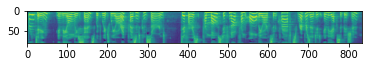

In [24]:
vocoder = Vocoder().to(device).eval()
waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform)
plt.imshow(mels[0].cpu())

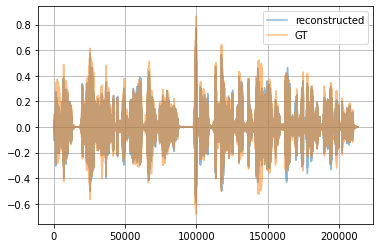

In [15]:
reconstructed_wav = vocoder.inference(mels).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [22]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /Users/timothyxp/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [75]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------
